## dataload & FeatureEngineering

Dataset of shape (2526700, 47)
Columns are ['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp', 'KnowledgeTag', 'kind', 'uidIdx', 'assIdx', 'testIdx', 'user_correct_answer', 'user_total_answer', 'user_acc', 'month', 'day', 'hour', 'dayname', 'big_category', 'problem_num', 'mid_category', 'test_mean', 'test_std', 'test_sum', 'tag_mean', 'tag_std', 'tag_sum', 'Timestamp2', 'solvetime', 'solvesec', 'solvesec_3600', 'time_category', 'solvesec_cumsum', 'solvecumsum_category', 'big_category_cumconut', 'big_category_answer', 'big_category_user_cum_acc', 'mid_category_cumconut', 'mid_category_answer', 'mid_category_user_cum_acc', 'ass_acc_mean', 'ass_difficulty', 'ass_acc_std', 'pb_num_acc_mean', 'pb_num_difficulty', 'pb_num_acc_std', 'assess_count', 'left_asymptote']
Parameter estimation is starting...


100%|██████████████████████████████| 2526700/2526700 [00:15<00:00, 159909.58it/s]


Theta & beta estimations on assessmentItemID are completed.
Dataset of shape (2526700, 48)
Columns are ['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp', 'KnowledgeTag', 'kind', 'uidIdx', 'assIdx', 'testIdx', 'user_correct_answer', 'user_total_answer', 'user_acc', 'month', 'day', 'hour', 'dayname', 'big_category', 'problem_num', 'mid_category', 'test_mean', 'test_std', 'test_sum', 'tag_mean', 'tag_std', 'tag_sum', 'Timestamp2', 'solvetime', 'solvesec', 'solvesec_3600', 'time_category', 'solvesec_cumsum', 'solvecumsum_category', 'big_category_cumconut', 'big_category_answer', 'big_category_user_cum_acc', 'mid_category_cumconut', 'mid_category_answer', 'mid_category_user_cum_acc', 'ass_acc_mean', 'ass_difficulty', 'ass_acc_std', 'pb_num_acc_mean', 'pb_num_difficulty', 'pb_num_acc_std', 'assess_count', 'left_asymptote', 'elo_assessmentItemID']
Parameter estimation is starting...


100%|██████████████████████████████| 2526700/2526700 [00:15<00:00, 161169.04it/s]


Theta & beta estimations on problem_num are completed.
User Tag TSNE Plot
Tag User TSNE Plot


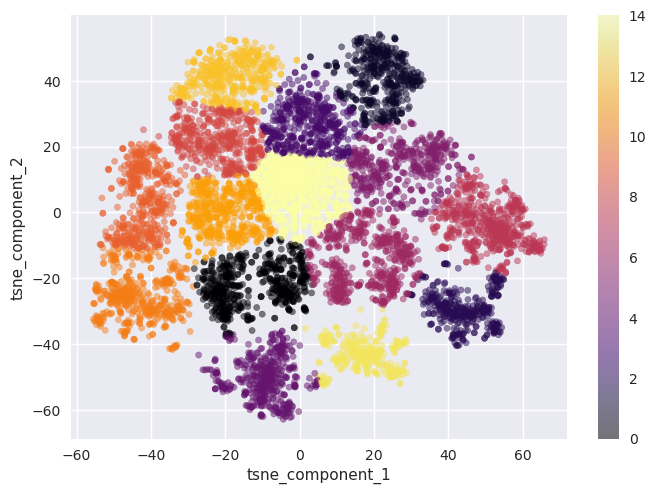

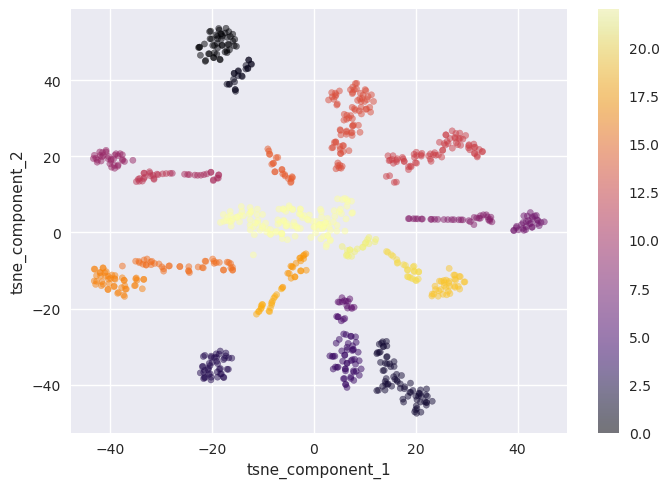

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import sys
plt.style.use('seaborn')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import missingno
import pandas as pd
pd.set_option('display.min_rows', 500)
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import hdbscan
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
sys.path.append('../LGBM/')
from utils import apply_elo_granularity_feature_name


def concat_and_export(train_fe, test_fe):
    
    train_fe['kind']='train'
    test_fe['kind']='test'
    
    df = pd.concat([train_fe,test_fe])
    data_dir = '/opt/ml/input/data' # 경로
    write_path=f'{data_dir}/after_fe_train_test_cumsum.pkl'
    df.to_pickle(write_path,index=False)
    print(f"Write: {write_path}")
    
def export(df, output='after_fe_train_test.pkl'):
    data_dir = '/opt/ml/input/data' # 경로
    write_path=f'{data_dir}/{output}'
    df.to_pickle(write_path)
    print(f"Write: {write_path}")
    
path='../../data/'
train = pd.read_csv(f"{path}/train_data.csv")
test = pd.read_csv(f"{path}/test_data.csv")

day_dict = {'Tuesday': 0,
 'Thursday': 1,
 'Monday': 2,
 'Saturday': 3,
 'Friday': 4,
 'Wednesday': 5,
 'Sunday': 6}

def feature_engineering(df):
    uid2idx = {v:k for k,v in enumerate(sorted(df.userID.unique()))}
    ass2idx = {v:k for k,v in enumerate(sorted(df.assessmentItemID.unique()))}
    test2idx = {v:k for k,v in enumerate(sorted(df.testId.unique()))}

    df2 = df.copy()
    #유저별 시퀀스를 고려하기 위해 아래와 같이 정렬
    df2.sort_values(by=['userID','Timestamp'], inplace=True)
    
    # userID, assessmentItemID, testId 라벨인코딩
    df2['uidIdx'] = df2.userID.map(uid2idx)
    df2['assIdx'] = df2.assessmentItemID.map(ass2idx)
    df2['testIdx'] = df2.testId.map(test2idx)
    
    #유저들의 문제 풀이수, 정답 수, 정답률을 시간순으로 누적해서 계산
    df2['user_correct_answer'] = df2.groupby('userID')['answerCode'].transform(lambda x: x.cumsum().shift(1))
    df2['user_total_answer'] = df2.groupby('userID')['answerCode'].cumcount()
    df2['user_acc'] = df2['user_correct_answer']/df2['user_total_answer']
    df2['month'] = pd.to_datetime(df2.Timestamp).dt.month
    df2['day'] = pd.to_datetime(df2.Timestamp).dt.day
    df2['hour'] = pd.to_datetime(df2.Timestamp).dt.hour
    df2['dayname'] = pd.to_datetime(df2.Timestamp).dt.day_name().map(day_dict)
    df2['big_category'] = df2.testId.map(lambda x:x[2]).astype(int)
    df2['problem_num'] = df2.assessmentItemID.map(lambda x: int(x[-3:]))
    df2['mid_category'] = df2.testId.map(lambda x: int(x[-3:]))

    # testId와 KnowledgeTag의 전체 정답률은 한번에 계산
    # 아래 데이터는 제출용 데이터셋에 대해서도 재사용
    correct_t = df2.groupby(['testId'])['answerCode'].agg(['mean', 'std', 'sum'])
    correct_t.columns = ["test_mean", "test_std", 'test_sum']
    correct_k = df2.groupby(['KnowledgeTag'])['answerCode'].agg(['mean', 'std', 'sum'])
    correct_k.columns = ["tag_mean", 'tag_std', 'tag_sum']

    df2 = pd.merge(df2, correct_t, on=['testId'], how="left")
    df2 = pd.merge(df2, correct_k, on=['KnowledgeTag'], how="left")
    
    # 유저별 문제푼 시간, solvesec_3600, time_category
    df2['Timestamp2'] = pd.to_datetime(df2.Timestamp)
    df2['solvetime'] = df2.groupby('userID')['Timestamp2'].diff().fillna(pd.Timedelta(seconds=0))
    df2['solvesec'] = df2.solvetime.map(lambda x : x.total_seconds())
    df2['solvesec_3600'] = df2.solvesec
    df2.loc[df2.solvesec>=3600,'solvesec_3600']=3600

    df2['time_category'] = ''
    tc = [0,5,7,10,60,600,1200,2400,3600]
    df2.loc[(df2.solvesec==0), 'time_category'] = "0 - [0,0]"
    for i in range(len(tc)-1):
        s,e = tc[i],tc[i+1]
        df2.loc[(df2.solvesec>s) & (df2.solvesec<=e),'time_category']=f"{i+1} - ({s}, {e}]"
    df2.loc[(df2.solvesec>=tc[-1]),'time_category'] = f"{i+2} - ({e}, )"
    timecat2idx={k:v for v,k in enumerate(sorted(df2.time_category.unique()))}
    df2['time_category'] = df2.time_category.map(timecat2idx)
    
    # 유저별 문제푼 시간 Cumsum
    df2['solvesec_cumsum'] = df2.groupby(['userID','testId'])['solvesec_3600'].cumsum()%3601
    df2['solvecumsum_category'] = ''
    tc = [0,5,7,10,60,600,1200,2400,3600,7200]
    df2.loc[(df2.solvesec_cumsum==0), 'solvecumsum_category'] = "0 - [0,0]"
    for i in range(len(tc)-1):
        s,e = tc[i],tc[i+1]
        df2.loc[(df2.solvesec_cumsum>s) & (df2.solvesec_cumsum<=e),'solvecumsum_category']=f"{i+1} - ({s}, {e}]"
    df2.loc[(df2.solvesec_cumsum>=tc[-1]),'solvecumsum_category'] = f"{i+2} - ({e}, )"
    solvecumsum_category2idx={k:v for v,k in enumerate(sorted(df2.solvecumsum_category.unique()))}
    df2['solvecumsum_category'] = df2.solvecumsum_category.map(solvecumsum_category2idx)
    
    ## big_category
    # big_category 전체 정답률, 표준편차
#     big_category_answermean = dict(df2.groupby("big_category").answerCode.mean())
#     big_category_answerstd = dict(df2.groupby("big_category").answerCode.std())
#     df2['big_category_acc'] = df2.big_category.map(big_category_answermean)
#     df2['big_category_std'] = df2.big_category.map(big_category_answerstd)

    # 유저별 big category 문제 푼 횟수, 맞춤 횟수, 누적 정답률
    df2['big_category_cumconut'] = df2.groupby(['userID','big_category']).answerCode.cumcount()
    df2['big_category_answer'] = df2.groupby(['userID','big_category']).answerCode.transform(lambda x: x.cumsum().shift(1)).fillna(0)
    df2['big_category_user_cum_acc'] = (df2['big_category_answer'] / df2['big_category_cumconut']).fillna(0)
    
    # 유저별 정답률, 표준 편차 (마지막제출 제외)
#     df2_user_big_ans = df2[df2.userID == df2.userID.shift(-1)].groupby(['userID','big_category']).answerCode.mean().reset_index()
#     df2_user_big_ans.rename(columns={'answerCode':'big_category_user_acc'},inplace=True)
#     df2 = df2.merge(df2_user_big_ans,on=['userID','big_category'])
    
#     df2_user_big_ans_std = df2[df2.userID == df2.userID.shift(-1)].groupby(['userID','big_category']).answerCode.std().reset_index()
#     df2_user_big_ans_std.rename(columns={'answerCode':'big_category_user_std'},inplace=True)
#     df2 = df2.merge(df2_user_big_ans_std,on=['userID','big_category'])   
    
    ## mid_category
    # mid_category 전체 정답률, 표준편차
#     mid_category_answermean = dict(df2.groupby("mid_category").answerCode.mean())
#     mid_category_answerstd = dict(df2.groupby("mid_category").answerCode.std())
#     df2['mid_category_acc'] = df2.mid_category.map(mid_category_answermean)
#     df2['mid_category_std'] = df2.mid_category.map(mid_category_answerstd)

    # 유저별 mid category 문제 푼 횟수, 맞춤 횟수, 누적 정답률
    df2['mid_category_cumconut'] = df2.groupby(['userID','mid_category']).answerCode.cumcount()
    df2['mid_category_answer'] = df2.groupby(['userID','mid_category']).answerCode.transform(lambda x: x.cumsum().shift(1)).fillna(0)
    df2['mid_category_user_cum_acc'] = (df2['mid_category_answer'] / df2['mid_category_cumconut']).fillna(0)

    # 유저별 정답률, 표준 편차 (마지막제출 제외)
#     df2_user_mid_ans = df2[df2.userID == df2.userID.shift(-1)].groupby(['userID','mid_category']).answerCode.mean().reset_index()
#     df2_user_mid_ans.rename(columns={'answerCode':'mid_category_user_acc'},inplace=True)
#     df2 = df2.merge(df2_user_mid_ans,on=['userID','mid_category'])

#     df2_user_mid_ans_std = df2[df2.userID == df2.userID.shift(-1)].groupby(['userID','mid_category']).answerCode.std().reset_index()
#     df2_user_mid_ans_std.rename(columns={'answerCode':'mid_category_user_std'},inplace=True)
#     df2 = df2.merge(df2_user_mid_ans_std,on=['userID','mid_category']) 


    ### 문항별 난이도
    ass_acc_dict = dict(df2[df2.answerCode!=-1].groupby('assessmentItemID').answerCode.mean())
    df2['ass_acc_mean'] = df2.assessmentItemID.map(ass_acc_dict)
    df2['ass_difficulty'] = 1 - df2['ass_acc_mean']
    
    ass_acc_std_dict = dict(df2[df2.answerCode!=-1].groupby('assessmentItemID').answerCode.std())
    df2['ass_acc_std'] = df2.assessmentItemID.map(ass_acc_std_dict)

    ### 문제 번호별 난이도
    pb_num_dict = dict(df2[df2.answerCode!=-1].groupby('problem_num').answerCode.mean())
    df2['pb_num_acc_mean'] = df2.problem_num.map(pb_num_dict)
    df2['pb_num_difficulty'] = 1 - df2['pb_num_acc_mean']
    
    pb_num_std_dict = dict(df2[df2.answerCode!=-1].groupby('problem_num').answerCode.std())
    df2['pb_num_acc_std'] = df2.problem_num.map(pb_num_std_dict)
    
    ## assess_count
    df2['assess_count'] = df2.groupby(['userID','assessmentItemID']).answerCode.cumcount()
    
    ## apply elo
    df2 = apply_elo_granularity_feature_name(df2, "assessmentItemID")
    df2 = apply_elo_granularity_feature_name(df2, "problem_num")
    df2.sort_values(by=['userID','Timestamp'], inplace=True)
    
    ## cluster
    user_tag_pivot = df2.pivot_table(values="answerCode", index="userID", columns="KnowledgeTag").fillna(0)
    tsne = TSNE(n_components=2, random_state=42)
    tsne_user_result = tsne.fit_transform(user_tag_pivot.values)
    tsne_user_df = pd.DataFrame(tsne_user_result, columns=['tsne_component_1', 'tsne_component_2'])
    number_of_clusters=15
    kmeans = KMeans(n_clusters=number_of_clusters, n_init=number_of_clusters, random_state=42)
    kmeans_labels=kmeans.fit_predict(tsne_user_result)
    print("User Tag TSNE Plot")
    tsne_user_df.plot(kind='scatter',x='tsne_component_1', y='tsne_component_2',alpha=0.5, c=kmeans_labels, colormap='inferno')
    tsne_user_dict = dict(zip(user_tag_pivot.index,kmeans_labels))
    df2['user_tag_cluster'] = df2.userID.map(tsne_user_dict)
    
    tag_user_pivot = df2.pivot_table(values="answerCode", index="KnowledgeTag", columns="userID").fillna(0)
    tsne = TSNE(n_components=2, random_state=42)
    tsne_tag_result = tsne.fit_transform(tag_user_pivot.values)
    tsne_tag_df = pd.DataFrame(tsne_tag_result, columns=['tsne_component_1', 'tsne_component_2'])
    clusterer = hdbscan.HDBSCAN(min_cluster_size=4, gen_min_span_tree=True)
    hdbscan_labels = clusterer.fit_predict(tsne_tag_result)    
    tsne_tag_df['labels'] = hdbscan_labels
    tsne_tag_df.loc[tsne_tag_df.labels==-1,'labels']=22
    print("Tag User TSNE Plot")
    tsne_tag_df.plot(kind='scatter',x='tsne_component_1', y='tsne_component_2',alpha=0.5, c=tsne_tag_df.labels, colormap='inferno')
    tsne_tag_dict = dict(zip(tag_user_pivot.index, tsne_tag_df.labels))
    df2['tag_cluster'] = df2.KnowledgeTag.map(tsne_tag_dict)
    
    user_mean_acc_dict = dict(df2[df2.answerCode!=-1].groupby("userID").answerCode.mean())
    df2['user_mean_acc'] = df2.userID.map(user_mean_acc_dict)

    big_category_grp = df2[df2.answerCode!=-1].groupby(["userID",'big_category']).answerCode.mean().reset_index()
    df2 = df2.merge(big_category_grp.rename(columns={'answerCode':'big_category_acc'}), on=['userID','big_category'], how='left')

    df2['big_category_acc_category'] = list(map(lambda x: int(round(x)+1),df2.big_category_acc*10))

    big_category_grp2 = df2[df2.answerCode!=-1].groupby(["userID",'big_category']).solvesec.mean().reset_index()
    df2 = df2.merge(big_category_grp2.rename(columns={'solvesec':'big_category_mean_solvesec'}), on=['userID','big_category'], how='left')
    df2['answerCodeshift'] = df2.groupby("userID").answerCode.shift(1)

    df2['user_acc_rolling_mean_10'] = df2.groupby("userID").answerCodeshift.rolling(10, min_periods=1).mean().values

    df2['tag_count'] = df2.groupby(['userID','KnowledgeTag']).cumcount()
    
    df2.sort_values(by=['userID','Timestamp'], inplace=True)
    return df2

train['kind']='train'
test['kind']='test'
df = pd.concat([train,test])
df = feature_engineering(df)
df2=df.copy()

## 내보내기

In [2]:
df2 = df.copy()
export(df2, output='base_lgbm2.pkl')

Write: /opt/ml/input/data/base_lgbm2.pkl
